# Zenvy Payroll Analytics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from sqlalchemy import create_engine
import pymysql
from urllib.parse import quote_plus
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="darkgrid")

In [2]:
employees = pd.read_csv('zenvy_employees.csv')
payroll = pd.read_csv('zenvy_payroll.csv')
attendance = pd.read_csv('zenvy_attendance.csv') 

In [3]:
    # --- COMBINE CSV FILES INTO MASTER ---
df = employees.merge(payroll, on='employee_id', how='left').merge(attendance, on='employee_id', how='left')

In [4]:
df.head()

,employee_id,employee_name,department,designation,base_salary,joining_date,gross_salary,tax_deduction,pf_deduction,net_salary,working_days,present_days,overtime_hours
0,1001,Aarav,IT,Developer,50000,2023-01-31,52500,5000.0,2500.0,45000.0,22,20,5
1,1002,Diya,HR,HR Executive,35000,2023-02-28,36000,3500.0,1750.0,30750.0,22,21,2
2,1003,Rohan,Finance,Accountant,40000,2023-03-31,40000,4000.0,2000.0,34000.0,22,19,0
3,1004,Sneha,IT,Developer,55000,2023-04-30,59000,5500.0,2750.0,50750.0,22,22,8
4,1005,Karan,Sales,Sales Exec,30000,2023-05-31,32000,3000.0,1500.0,27500.0,22,20,4


In [5]:
df.shape

(20, 13)

# **Feature Engineering for visuals**

In [6]:

df['attendance_ratio'] = (df['present_days'] / df['working_days']) * 100
df['allowances'] = df['gross_salary'] - df['base_salary']

In [7]:
df.head()

,employee_id,employee_name,department,designation,base_salary,joining_date,gross_salary,tax_deduction,pf_deduction,net_salary,working_days,present_days,overtime_hours,attendance_ratio,allowances
0,1001,Aarav,IT,Developer,50000,2023-01-31,52500,5000.0,2500.0,45000.0,22,20,5,90.909091,2500
1,1002,Diya,HR,HR Executive,35000,2023-02-28,36000,3500.0,1750.0,30750.0,22,21,2,95.454545,1000
2,1003,Rohan,Finance,Accountant,40000,2023-03-31,40000,4000.0,2000.0,34000.0,22,19,0,86.363636,0
3,1004,Sneha,IT,Developer,55000,2023-04-30,59000,5500.0,2750.0,50750.0,22,22,8,100.000000,4000
4,1005,Karan,Sales,Sales Exec,30000,2023-05-31,32000,3000.0,1500.0,27500.0,22,20,4,90.909091,2000


In [8]:
df.shape 

(20, 15)

# --- CONVERT JOINING_DATE TO DATETIME ---

In [9]:
# --- CONVERT JOINING_DATE TO DATETIME ---
df['joining_date'] = pd.to_datetime(df['joining_date'])

In [10]:
# --- ADD DATE DIMENSION COLUMNS ---
# 1. date (Primary Key)
df['date'] = df['joining_date']

# 2. day
df['day'] = df['joining_date'].dt.day

# 3. month
df['month'] = df['joining_date'].dt.month

# 4. month_name
df['month_name'] = df['joining_date'].dt.strftime('%B')

# 5. quarter
df['quarter'] = df['joining_date'].dt.quarter

# 6. year
df['year'] = df['joining_date'].dt.year

df[['employee_name', 'date', 'day', 'month', 'month_name', 'quarter', 'year']].head(10)

,employee_name,date,day,month,month_name,quarter,year
0,Aarav,2023-01-31,31,1,January,1,2023
1,Diya,2023-02-28,28,2,February,1,2023
2,Rohan,2023-03-31,31,3,March,1,2023
3,Sneha,2023-04-30,30,4,April,2,2023
4,Karan,2023-05-31,31,5,May,2,2023
5,Meera,2023-06-30,30,6,June,2,2023
6,Vikram,2023-07-31,31,7,July,3,2023
7,Ananya,2023-08-31,31,8,August,3,2023
8,Rahul,2023-09-30,30,9,September,3,2023
9,Pooja,2023-10-31,31,10,October,4,2023


In [11]:
df.shape

(20, 21)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   employee_id       20 non-null     int64         
 1   employee_name     20 non-null     object        
 2   department        20 non-null     object        
 3   designation       20 non-null     object        
 4   base_salary       20 non-null     int64         
 5   joining_date      20 non-null     datetime64[ns]
 6   gross_salary      20 non-null     int64         
 7   tax_deduction     20 non-null     float64       
 8   pf_deduction      20 non-null     float64       
 9   net_salary        20 non-null     float64       
 10  working_days      20 non-null     int64         
 11  present_days      20 non-null     int64         
 12  overtime_hours    20 non-null     int64         
 13  attendance_ratio  20 non-null     float64       
 14  allowances        20 non-nul

In [13]:
df.columns

Index(['employee_id', 'employee_name', 'department', 'designation',
       'base_salary', 'joining_date', 'gross_salary', 'tax_deduction',
       'pf_deduction', 'net_salary', 'working_days', 'present_days',
       'overtime_hours', 'attendance_ratio', 'allowances', 'date', 'day',
       'month', 'month_name', 'quarter', 'year'],
      dtype='object')

In [14]:
df.dtypes

employee_id                  int64
employee_name               object
department                  object
designation                 object
base_salary                  int64
joining_date        datetime64[ns]
gross_salary                 int64
tax_deduction              float64
pf_deduction               float64
net_salary                 float64
working_days                 int64
present_days                 int64
overtime_hours               int64
attendance_ratio           float64
allowances                   int64
date                datetime64[ns]
day                          int32
month                        int32
month_name                  object
quarter                      int32
year                         int32
dtype: object

In [15]:
df.isnull().sum()

employee_id         0
employee_name       0
department          0
designation         0
base_salary         0
joining_date        0
gross_salary        0
tax_deduction       0
pf_deduction        0
net_salary          0
working_days        0
present_days        0
overtime_hours      0
attendance_ratio    0
allowances          0
date                0
day                 0
month               0
month_name          0
quarter             0
year                0
dtype: int64

In [16]:
df.duplicated().sum()

np.int64(0)

In [17]:
df.describe()

,employee_id,base_salary,joining_date,gross_salary,tax_deduction,pf_deduction,net_salary,working_days,present_days,overtime_hours,attendance_ratio,allowances,date,day,month,quarter,year
count,20.00000,20.000000,20,20.000000,20.000000,20.000000,20.000000,20.0,20.000000,20.000000,20.000000,20.000000,20,20.000000,20.000000,20.000000,20.000000
mean,1010.50000,53950.000000,2023-11-14 20:24:00,56150.000000,5395.000000,2697.500000,48057.500000,22.0,20.600000,4.400000,93.636364,2200.000000,2023-11-14 20:24:00,30.450000,5.700000,2.250000,2023.400000
min,1001.00000,30000.000000,2023-01-31 00:00:00,32000.000000,3000.000000,1500.000000,27500.000000,22.0,19.000000,0.000000,86.363636,0.000000,2023-01-31 00:00:00,28.000000,1.000000,1.000000,2023.000000
25%,1005.75000,35750.000000,2023-06-22 12:00:00,36375.000000,3575.000000,1787.500000,31012.500000,22.0,20.000000,2.000000,90.909091,1000.000000,2023-06-22 12:00:00,30.000000,3.000000,1.000000,2023.000000
50%,1010.50000,51000.000000,2023-11-15 00:00:00,54000.000000,5100.000000,2550.000000,46350.000000,22.0,21.000000,4.000000,95.454545,2000.000000,2023-11-15 00:00:00,31.000000,5.500000,2.000000,2023.000000
75%,1015.25000,71250.000000,2024-04-07 12:00:00,72500.000000,7125.000000,3562.500000,61812.500000,22.0,21.250000,6.250000,96.590909,3125.000000,2024-04-07 12:00:00,31.000000,8.000000,3.000000,2024.000000
max,1020.00000,90000.000000,2024-08-31 00:00:00,96000.000000,9000.000000,4500.000000,82500.000000,22.0,22.000000,12.000000,100.000000,6000.000000,2024-08-31 00:00:00,31.000000,12.000000,4.000000,2024.000000
std,5.91608,20011.772851,NaN,21156.745845,2001.177285,1000.588643,18161.347584,0.0,1.095445,3.377947,4.979296,1688.973528,NaN,0.825578,3.278318,1.069924,0.502625


# Part 1 : Data Cleaning & Format Standardization

In [18]:
# Cleaning Employees Data
if 'department' in df.columns:
    df['department'] = df['department'].str.strip().str.upper()

if 'designation' in df.columns:
    df['designation'] = df['designation'].str.strip().str.title()

if 'employee_name' in df.columns:
    df['employee_name'] = df['employee_name'].str.strip().str.title()

if 'joining_date' in df.columns:
    df['joining_date'] = pd.to_datetime(df['joining_date'], errors='coerce')

# Handle Numerical Inconsistencies
if 'base_salary' in df.columns:
    df['base_salary'] = df['base_salary'].fillna(0)

print("Data cleaning completed.")
df[['department', 'designation', 'employee_name', 'joining_date', 'base_salary']].head()


Data cleaning completed.


,department,designation,employee_name,joining_date,base_salary
0,IT,Developer,Aarav,2023-01-31,50000
1,HR,Hr Executive,Diya,2023-02-28,35000
2,FINANCE,Accountant,Rohan,2023-03-31,40000
3,IT,Developer,Sneha,2023-04-30,55000
4,SALES,Sales Exec,Karan,2023-05-31,30000


# Part 2: Merging & Basic EDA

In [19]:
final_df = pd.merge(employees,payroll,on='employee_id',how='left')

final_df = pd.merge(final_df,attendance,on='employee_id',how='left')

final_df.fillna(0, inplace=True)

if 'gross_salary' in final_df.columns:
    final_df['ctc'] = final_df['gross_salary']

print(f"Combined Dataset Shape: {final_df.shape}")
final_df.head()


Combined Dataset Shape: (20, 14)


,employee_id,employee_name,department,designation,base_salary,joining_date,gross_salary,tax_deduction,pf_deduction,net_salary,working_days,present_days,overtime_hours,ctc
0,1001,Aarav,IT,Developer,50000,2023-01-31,52500,5000.0,2500.0,45000.0,22,20,5,52500
1,1002,Diya,HR,HR Executive,35000,2023-02-28,36000,3500.0,1750.0,30750.0,22,21,2,36000
2,1003,Rohan,Finance,Accountant,40000,2023-03-31,40000,4000.0,2000.0,34000.0,22,19,0,40000
3,1004,Sneha,IT,Developer,55000,2023-04-30,59000,5500.0,2750.0,50750.0,22,22,8,59000
4,1005,Karan,Sales,Sales Exec,30000,2023-05-31,32000,3000.0,1500.0,27500.0,22,20,4,32000


# **Correlation Matrix**

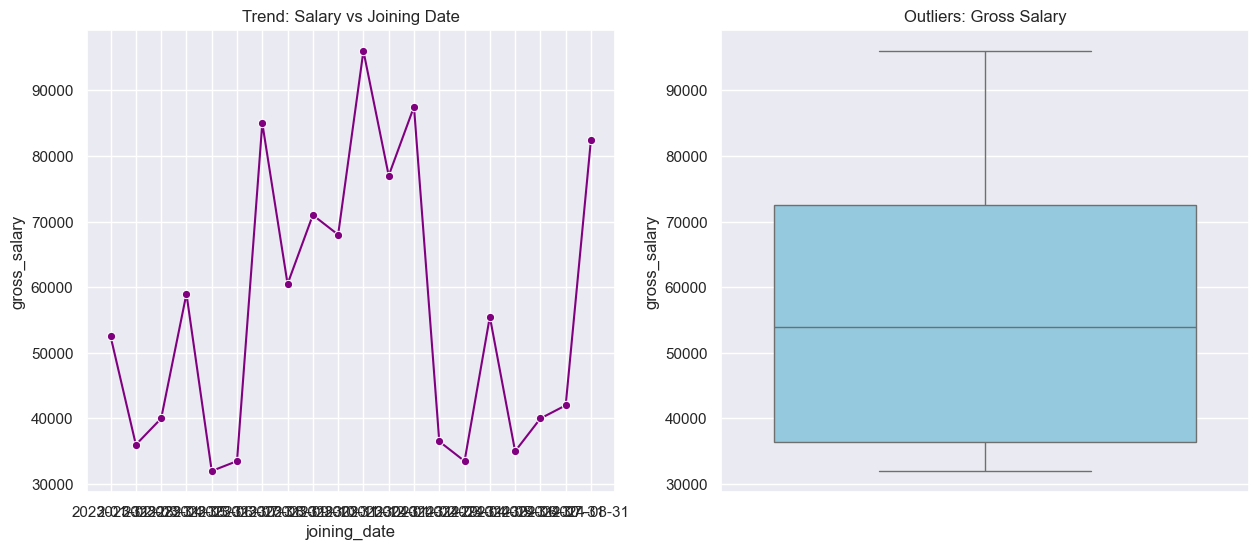

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.lineplot(data=final_df, x='joining_date', y='gross_salary', marker='o', ax=axes[0], color='purple')
axes[0].set_title('Trend: Salary vs Joining Date')

sns.boxplot(y=final_df['gross_salary'], color='skyblue', ax=axes[1])
axes[1].set_title('Outliers: Gross Salary')

plt.show()

# **Trend & Outliers**

# Correlation Matrix of Payroll Features (Heatmap)

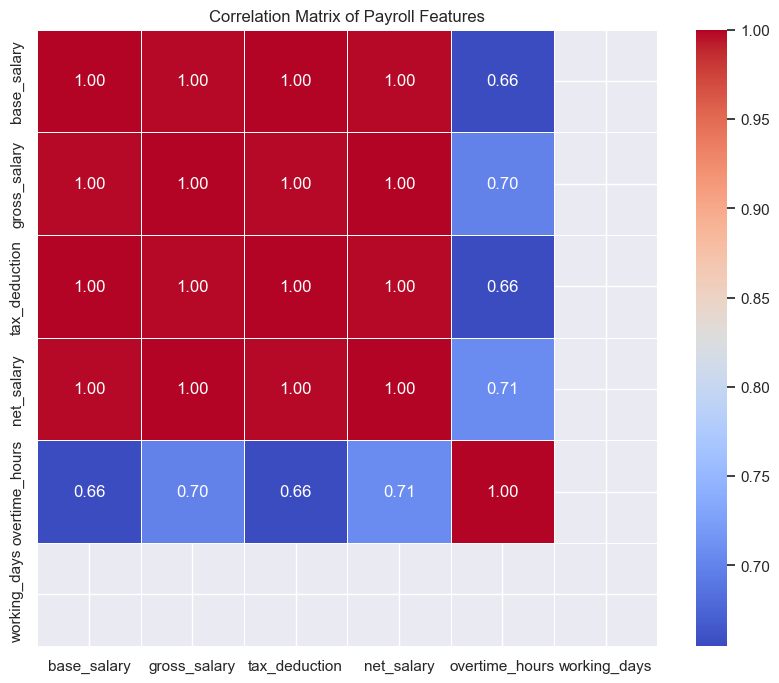

In [21]:
corr_cols = ['base_salary', 'gross_salary', 'tax_deduction', 'net_salary', 'overtime_hours', 'working_days']
corr_matrix = final_df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Payroll Features')
plt.show()

# Salary Distribution Histogram

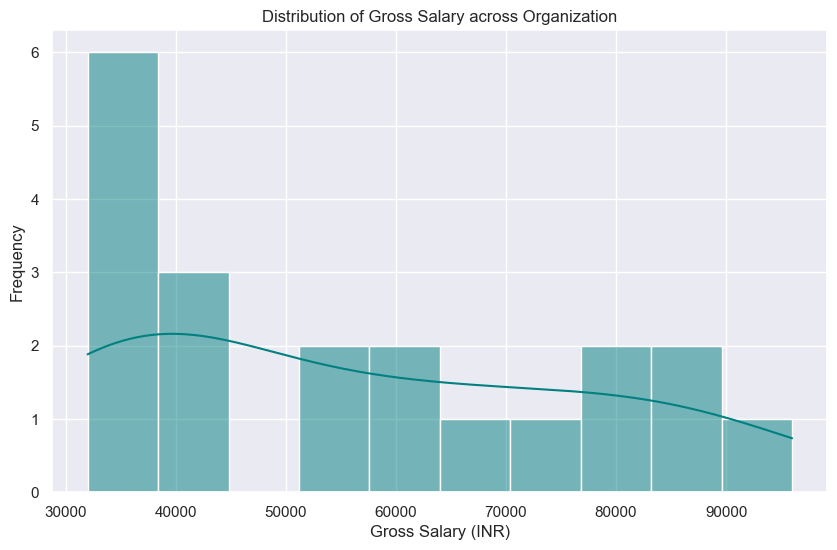

In [22]:
# 1. Salary Distribution Histogram
plt.figure(figsize=(10,6))
sns.histplot(final_df['gross_salary'], bins=10, kde=True, color='teal')
plt.title('Distribution of Gross Salary across Organization')
plt.xlabel('Gross Salary (INR)')
plt.ylabel('Frequency')
plt.show()

# Total Payroll Expenses by Department

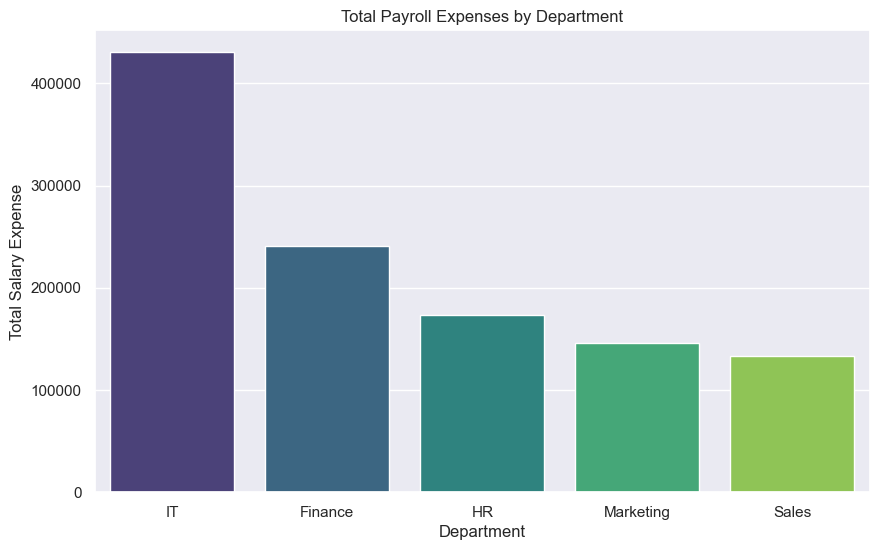

In [23]:
# 2. Department-wise Payroll Expenses
dept_expense = final_df.groupby('department')['gross_salary'].sum().reset_index().sort_values(by='gross_salary', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=dept_expense, x='department', y='gross_salary', palette='viridis')
plt.title('Total Payroll Expenses by Department')
plt.ylabel('Total Salary Expense')
plt.xlabel('Department')
plt.show()

# Overtime Hours Distribution by Department

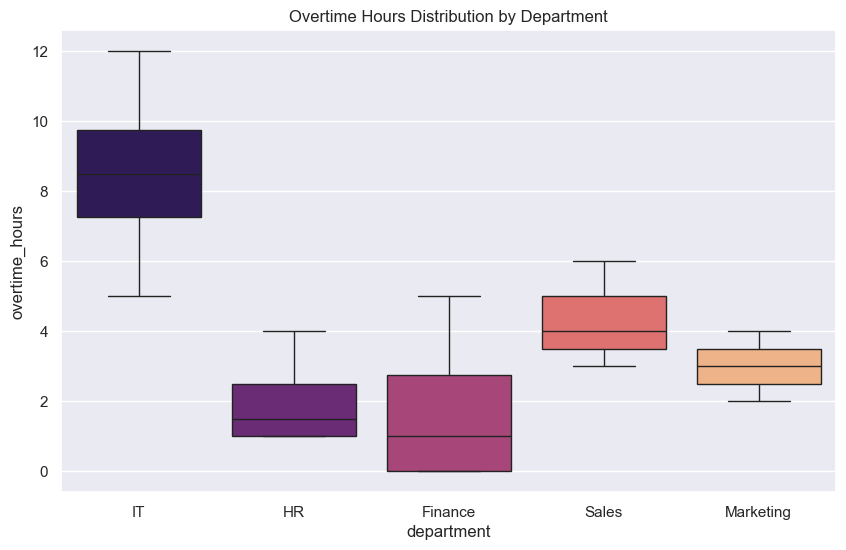

In [24]:
# 3. Department-wise Payroll Expenses
plt.figure(figsize=(10,6))
sns.boxplot(data=final_df, x='department', y='overtime_hours', palette='magma')
plt.title('Overtime Hours Distribution by Department')
plt.show()

#  **● Build first mock dashboards**
# **○ Salary distribution chart**
# **○ Department-wise payroll expenses**

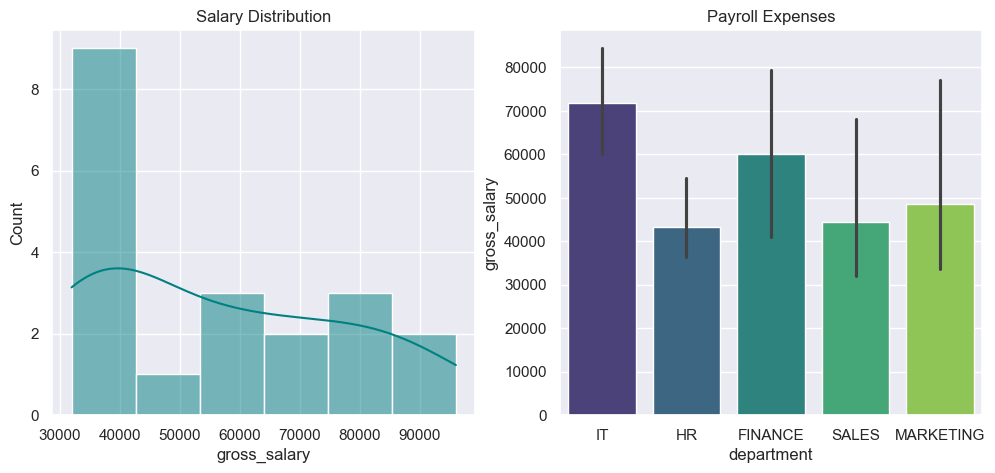

In [25]:
# VISUALIZATION
if 'df' in locals():
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(df['gross_salary'], kde=True, ax=ax[0], color='teal').set_title('Salary Distribution')
    sns.barplot(data=df, x='department', y='gross_salary', ax=ax[1], palette='viridis').set_title('Payroll Expenses')
    plt.show()

## Export for Power BI

In [26]:
df.to_csv('zenvy_master_for_powerbi.csv', index=False)
print("Master dataset exported: zenvy_master_for_powerbi.csv")

Master dataset exported: zenvy_master_for_powerbi.csv


# Part 3: MySQL Integration

In [27]:
#  AUTO MYSQL CONNECT & MIGRATION

# --- NEW DATABASE NAME ---
DB_NAME = 'zenvy_payroll_analytics'  # <--- Changed Name

DB_HOST = 'localhost'
DB_USER = 'root'
Passwords_To_Try = ["Password@123", "", "root", "password"]

successful_engine = None

def connect_and_migrate(password):
    try:
        print(f"Attempting connection with password: '{password}' ...")
        # 1. Connect to Server (No DB selected yet) to Create DB
        conn = pymysql.connect(host=DB_HOST, user=DB_USER, password=password)
        cursor = conn.cursor()
        cursor.execute(f"CREATE DATABASE IF NOT EXISTS {DB_NAME}")
        conn.close()
        print(f"   -> Database '{DB_NAME}' ensured.")
        
        # 2. Connect to Database using SQLAlchemy for DataFrame upload
        encoded_pass = quote_plus(password)
        engine = f"mysql+pymysql://{DB_USER}:{encoded_pass}@{DB_HOST}:3306/{DB_NAME}"
        engine = create_engine(engine)
        
        # Test connection
        with engine.connect() as conn:
            pass
            
        # Upload
        master_data = df.copy()
        master_data.to_sql('master_payroll_record', con=engine, if_exists='replace', index=False)
        
        print(f"✅ SUCCESS! Connected & Migrated to '{DB_NAME}'.")
        return engine
    except Exception as e:
        print(f"   -> Failed: {e}")
        return None

In [28]:
# Try passwords loop
for pwd in Passwords_To_Try:
    successful_engine = connect_and_migrate(pwd)
    if successful_engine:
        break

if not successful_engine:
    print("\n❌ ALL PASSWORD ATTEMPTS FAILED. Please check your MySQL setup.")

Attempting connection with password: 'Password@123' ...
   -> Database 'zenvy_payroll_analytics' ensured.
✅ SUCCESS! Connected & Migrated to 'zenvy_payroll_analytics'.


# Data Migration: Upload Cleaned DataFrames from the list 'df'

In [29]:

try:
    employees.to_sql('employees',con=successful_engine,if_exists='replace',index=False)

    payroll.to_sql('payroll',con=successful_engine,if_exists='replace',index=False)
    
    attendance.to_sql('attendance',con=successful_engine,if_exists='replace',index=False)

    print("✅ Migration successful! Tables created: employees, payroll, attendance")

except Exception as e:
    print(f"❌ Migration failed: {e}")


✅ Migration successful! Tables created: employees, payroll, attendance


# Part 4: **Advanced Analytics SQL**

## SQL Query: Fetch Master Data

In [30]:
master_query = """
SELECT 
    e.*,
    p.gross_salary, p.tax_deduction, p.net_salary,
    a.working_days, a.overtime_hours
FROM employees e
JOIN payroll p ON e.employee_id = p.employee_id
JOIN attendance a ON e.employee_id = a.employee_id;
"""

df_master_sql = pd.read_sql(master_query, successful_engine)

df_master_sql['joining_date'] = pd.to_datetime(df_master_sql['joining_date'])

df_master_sql.head()


,employee_id,employee_name,department,designation,base_salary,joining_date,gross_salary,tax_deduction,net_salary,working_days,overtime_hours
0,1001,Aarav,IT,Developer,50000,2023-01-31,52500,5000.0,45000.0,22,5
1,1002,Diya,HR,HR Executive,35000,2023-02-28,36000,3500.0,30750.0,22,2
2,1003,Rohan,Finance,Accountant,40000,2023-03-31,40000,4000.0,34000.0,22,0
3,1004,Sneha,IT,Developer,55000,2023-04-30,59000,5500.0,50750.0,22,8
4,1005,Karan,Sales,Sales Exec,30000,2023-05-31,32000,3000.0,27500.0,22,4


#  SQL ANALYTICS

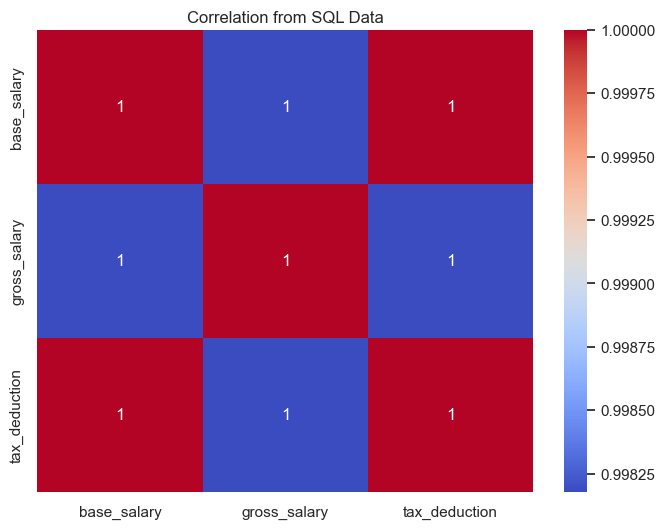

In [31]:

if successful_engine:
    try:
        query = "SELECT * FROM master_payroll_record"
        sql_df = pd.read_sql(query, successful_engine)
        
        plt.figure(figsize=(8,6))
        sns.heatmap(sql_df[['base_salary', 'gross_salary', 'tax_deduction']].corr(), annot=True, cmap='coolwarm')
        plt.title("Correlation from SQL Data")
        plt.show()
    except Exception as e:
        print(e)